Thanks for taking your time to complete this take-home task. 

This is where you can show off all your decision science skills through a hands-on project. Together with the dataset, this notebook presents a series of typical problems we face in our job. We expect you to complete the notebook with insightful analysis, elegant code and clear documentation of your findings (perfectly OK to embed within this notebook, just make sure using a distinct color). Please also feel free to keep in the final notebook any code+result where you believe there is value, even if it's not directly addressing the questions below.

We have designed this test with the hope to only take you about 3 hours. We know it’s still quite a commitment of your time and we really appreciate it. That being said, this test is not timed so feel free to spend more time if needed. We’d love to hear your feedback if it actually cost you longer than we intended. It is easy for us to underestimate the required efforts when we know the answers already! Please also tell us if you haven’t had enough fun 😂


## Hints

*   We encourage our decision scientists to use open-source solutions as much as possible instead of re-inventing the wheels. So please feel free to Google for a solution before writing any complicated code. 
*   If you are running short of time but have lots of extra great ideas you'd like to explore, feel free to write down your thoughts in words or pseudo-code instead of code.

## Context

The project we have here is to validate and monitor two credit risk decision models for personal loan underwriting decisions. The information we collected at the underwriting stage of successful applications (i.e. approved and disbursed) were used as the input features of these two models. The two models were trained to predict whether the customers will repay all scheduled payment in the following X months. 

We can split our data into the following three parts:
1.   the **development sample**: all loans applications before 1st August 2019
2.   the **out-of-time monitoring sample**: all loans applications between 1st August 2019 and 1st Jan 2020
3.   the **post-deployment monitoring sample**: all loans applications since 1st Jan 2020


An extended question: assuming that classification power is all we care about, what are the other reasons to not pick the model with highest Gini? It's enough to just write down your thoughts. 


# Part 1. Data processing



## Task 1.1: data cleaning

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
import warnings

plt.style.use('ggplot')

In [383]:
mo_df = pd.read_csv("./data/monthly_outcome.csv")
ap_df = pd.read_csv("./data/application.csv")

In [384]:
# CHECK DATA TYPES
# Results:
## 1. status: object -> Suggests mixed data types, explore
## 2. date, origination_date: object -> Cast to datetime
print("Data types for mo_df:")
print(mo_df.dtypes)

print("\nData types for ap_df:")
print(ap_df.dtypes)


Data types for mo_df:
unique_id     int64
date         object
status       object
dtype: object

Data types for ap_df:
unique_id                                    int64
stress_score                               float64
is_bad_12m                                 float64
model_1                                    float64
model_2                                    float64
origination_date                            object
loan_term                                  float64
loan_amount                                float64
age_oldest_account                         float64
total_value_of_mortgage                    float64
current_utilisation                        float64
months_since_2_payments_missed             float64
number_of_credit_searches_last_3_months    float64
dtype: object


In [385]:
# Explore unique values in status column
# Result: Integers and floats are mixed, codyfing the same status in different ways (e.g. 1 and 1.0)
print(mo_df.groupby('status').size())
# keep only first element of str in status column
mo_df['status'] = mo_df['status'].str[0]
# Change D to 4 for easier handling
mo_df['status'] = mo_df['status'].replace('D', '4').astype(int)
print('Fixed:', mo_df.groupby('status').size())

status
0      324703
0.0    470201
1       10592
1.0     15524
2        3141
2.0      5259
3        1190
3.0      1296
D       16074
dtype: int64
Fixed: status
0    794904
1     26116
2      8400
3      2486
4     16074
dtype: int64


In [386]:
# CHECK FOR NULLS OR NAs
# Result:
## 1. NULLs for is_bad_12m -> Explore
## 2.stress_score -> Likely fine as variable available from late 2019 onwards
print('---- monthly_outcome.csv ----')
print(f'Nulls or NAs per column in monthly_outcome.csv:\n',mo_df.isnull().sum() + mo_df.isna().sum())
print('---- application.csv ----')
print(f'Nulls or NAs per column in application.csv:\n',ap_df.isnull().sum() + ap_df.isna().sum())


---- monthly_outcome.csv ----
Nulls or NAs per column in monthly_outcome.csv:
 unique_id    0
date         0
status       0
dtype: int64
---- application.csv ----
Nulls or NAs per column in application.csv:
 unique_id                                      0
stress_score                               96060
is_bad_12m                                  9124
model_1                                        0
model_2                                        0
origination_date                               0
loan_term                                      0
loan_amount                                    0
age_oldest_account                             0
total_value_of_mortgage                        0
current_utilisation                            0
months_since_2_payments_missed                 0
number_of_credit_searches_last_3_months        0
dtype: int64


In [387]:
# Missing values for is_bad_12m?
# Results:
## 4.5K unique_ids with missing is_bad_12m, no obvious reason why this is happening.
## Likely could have recreated the variable, but for the sake of time, I will drop the unique ids from both datasets


# Supress warnings for this cell, to get rid of .iloc warnings
warnings.filterwarnings("ignore")


# List of users where is_bad_12m is missing
unique_id_missing_is_bad_12m = list(ap_df[ap_df['is_bad_12m'].isnull()].unique_id)
print(f'Number of unique_id with missing is_bad_12m: {len(unique_id_missing_is_bad_12m)}')

# Checking a few examples, I cannot see a reason why is_bad_12m is missing. I was suspecting that not enough time passed, but this is not the case
mo_df.query(f'unique_id=={unique_id_missing_is_bad_12m[0]}')
            
# is_bad_12m can be recreated based on monthly_outcome.csv, we write this as a function to later use it to create the 3m target
def add_xmonth_default_flag(ap_df, mo_df, m, y=3, col_suffix='_new'):
    # order mo_df by unique_id and date
    mo_df = mo_df.sort_values(by=['unique_id', 'date'], ascending=[True, True]).reset_index(drop=True)
    # row_number for each unique_id
    mo_df['row_number'] = mo_df.groupby('unique_id').cumcount()+1
    # keep only row-X for each unique_id
    mo_df_reduced =  mo_df.query(f'row_number=={m}')
    # Check if by row-X, y have been missed
    mo_df_reduced[f'is_bad_{m}m{col_suffix}']  = mo_df_reduced['status'].apply(lambda x: 1.0 if x>=y else 0.0)
    mo_df_reduced = mo_df_reduced[['unique_id', f'is_bad_{m}m{col_suffix}']]
    # left join with ap_df
    ap_df = ap_df.merge(mo_df_reduced, on='unique_id', how='left')
    return ap_df

ap_df = add_xmonth_default_flag(ap_df, mo_df, 12, 3)


Number of unique_id with missing is_bad_12m: 4562


In [388]:
# Cross tabulation of is_bad_12m and is_bad_12m_new
# Results: The function agrees with the existing is_bad_12m wherever its not NULL, we can thus replace is_bad_12m with is_bad_12m_new
# There is 40 cases where the 2 variables disagre, but this happens because status is broken for those cases
pd.crosstab(ap_df['is_bad_12m'].fillna(999), ap_df['is_bad_12m_new'].fillna(999))

is_bad_12m_new,0.0,1.0
is_bad_12m,,
0.0,68995,0
1.0,40,2721
999.0,4562,0


In [389]:

# Replace is_bad_12m with is_bad_12m_new
ap_df['is_bad_12m'] = ap_df['is_bad_12m_new']
ap_df = ap_df.drop(columns=['is_bad_12m_new'])

In [390]:
## Why is there missing values for 'stress_score'?
# According to questions this became only available in late 2019.
# Will not confirm in the interest of time that this is the entire source for missing values

Text(0.5, 0, '')

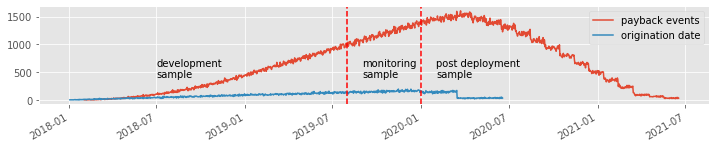

In [391]:
# CONVERT DATE COLUMNS TO DATETIME
mo_df["date"] = pd.to_datetime(mo_df["date"])
ap_df["origination_date"] = pd.to_datetime(ap_df["origination_date"])

plt.figure(figsize=(12,2))

mo_df.groupby("date").size().plot()
ap_df.groupby("origination_date").size().plot()

# add verticle lines on 2019-08-01 and 2020-01-01
plt.axvline(x=pd.to_datetime("2019-08-01"), color="red", linestyle="--")
plt.axvline(x=pd.to_datetime("2020-01-01"), color="red", linestyle="--")
# add text at 2018-07 saying 'development sample'
plt.text(pd.to_datetime("2018-07-01"), 400, "development\nsample")
plt.text(pd.to_datetime("2019-09-01"), 400, "monitoring\nsample")
plt.text(pd.to_datetime("2020-02-01"), 400, "post deployment\nsample")

plt.legend(["payback events", "origination date"])
plt.xlabel("")

In [392]:
## EXPLORE STATUS COLUMN: Does it work as described?
# 1. Exactly 12 payback events per unique_id? -> Yes
# 2. Always 1 month between payback events for each users? -> Yes
# 3. Status always increases by 1 or 0? -> No, remove unique_ids where this is not the case

In [393]:
# 1. Exactly 12 payback events per unique_id?
# Result: Yes
print('All unique_ids have 12 payback events: ', mo_df.groupby('unique_id').size().value_counts())

All unique_ids have 12 payback events:  12    70665
Name: count, dtype: int64


(array([0, 1]), [Text(0, 0, '30.0'), Text(1, 0, '31.0')])

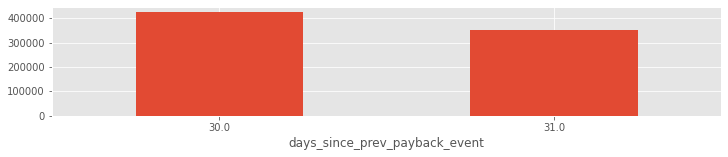

In [394]:
# 2. Always 1 month between payback events for each users? -> Yes
mo_df = mo_df.sort_values(by=['unique_id', 'date'], ascending=[True, True]).reset_index(drop=True)
mo_df['prev_date'] = mo_df.groupby('unique_id')['date'].shift(1)
mo_df['days_since_prev_payback_event'] = (mo_df['date'] - mo_df['prev_date']).dt.days

# Plot distribution of days since previous payback event as barchart
plt.figure(figsize=(12,2))
mo_df['days_since_prev_payback_event'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)

In [395]:

# 3. The status column should always increase by 0 or 1 from month to month
# This is true under the assumption that every month 1 payment is due and either gets paid (no status change) or not (status +1)
mo_df = mo_df.sort_values(by=['unique_id', 'date'], ascending=[True, True]).reset_index(drop=True)
# get previous status for each unique_id
mo_df['prev_status'] = mo_df.groupby('unique_id')['status'].shift(1)
mo_df['status_delta_previous_period'] = mo_df['status'] - mo_df['prev_status'] 

# Count how often status_delta_previous_period is not 0 or 1 or NaN
print(mo_df[~mo_df['status_delta_previous_period'].isin([0, 1, np.nan])].groupby('status_delta_previous_period').size())

# Explored examples where the status changes by -3, -2, -1, 2, 3, 4. Seems like corruption in the data.
example_user = list(mo_df.query('status_delta_previous_period==-3')['unique_id'])[0]
mo_df.query(f'unique_id == {example_user}')

# Identify users with corrupted status and remove from analysis (13K unique_ids)
unique_ids_for_removal = mo_df[mo_df['status_delta_previous_period'].isin([-3, -2, -1, 2, 3, 4])]['unique_id'].unique()
print('Removed number of unique_ids: ', len(unique_ids_for_removal))
mo_df = mo_df[~mo_df['unique_id'].isin(unique_ids_for_removal)]
ap_df = ap_df[~ap_df['unique_id'].isin(unique_ids_for_removal)]


status_delta_previous_period
-3.0       49
-2.0     3317
-1.0    14314
 2.0       22
 3.0       29
 4.0      182
dtype: int64
Removed number of unique_ids:  12956


In [396]:
#  Number unique_id in monthly_outcome.csv and application.csv, and do they match?
# Yes, there is the same 70K unique_id in both files
print("Number of unique_id in mo_df:", mo_df['unique_id'].nunique())
print("Number of unique_id in ap_df:", ap_df['unique_id'].nunique())
print("Number of unique_id in both:", len(set(mo_df['unique_id']).intersection(set(ap_df['unique_id']))))

Number of unique_id in mo_df: 57709
Number of unique_id in ap_df: 57709
Number of unique_id in both: 57709


In [397]:
## Duplicate check

# 1. monthly_outcome.csv: Unique identifier should by unique_id and date -> No duplicates
print(f'Duplicates in monthly_outcome.csv:', mo_df.duplicated(subset=['unique_id','date']).sum())

# 2. application.csv: Unique identifier should by unique_id -> 5K duplicates (Ou)
print(f'Duplicates in application.csv:',ap_df.duplicated(subset=['unique_id']).sum())

# Have a look at the duplicated unique_ids -> They appear to be simple copies of the same data
ap_df[ap_df.duplicated(subset=['unique_id'],keep=False)].sort_values('unique_id')
# Drop duplicates and rerun the check to confirm they are all gone
ap_df = ap_df.drop_duplicates()
print(f'Duplicates in application.csv after drop:',ap_df.duplicated(subset=['unique_id']).sum())

Duplicates in monthly_outcome.csv: 0
Duplicates in application.csv: 4565
Duplicates in application.csv after drop: 0


In [398]:
# sumarize the df ap_df
# Result: Strange min numbers (-999997.0) for 'age_oldest_account', 'total_value_of_mortgage', 'current_utilisation', 'months_since_2_payments_missed'
print(ap_df.describe())

          unique_id  stress_score    is_bad_12m       model_1       model_2  \
count  57709.000000  21566.000000  57709.000000  57709.000000  57709.000000   
mean   43924.263217      0.449519      0.033357      0.027099      0.026761   
min        0.000000      0.023592      0.000000      0.000438      0.000372   
25%    21981.000000      0.333783      0.000000      0.004606      0.005909   
50%    43947.000000      0.447238      0.000000      0.012971      0.016939   
75%    65889.000000      0.561265      0.000000      0.034743      0.033897   
max    87958.000000      0.932402      1.000000      0.449751      0.430226   
std    25383.933948      0.157893      0.179569      0.037191      0.032809   

                    origination_date     loan_term   loan_amount  \
count                          57709  57709.000000  57709.000000   
mean   2019-06-25 06:08:54.114263040     34.358662   6157.325200   
min              2018-01-03 00:00:00     12.000000    200.000000   
25%             

In [399]:
columns_to_replace_low_values = [
    'age_oldest_account', 
    'total_value_of_mortgage', 
    'current_utilisation', 
    'months_since_2_payments_missed', 
    'number_of_credit_searches_last_3_months'
]

# Loop through each column and print the groupby and size
for column in columns_to_replace_low_values:
    print(ap_df.groupby(column).size().sort_index())

# Replace low values with NaN
ap_df[columns_to_replace_low_values] = ap_df[columns_to_replace_low_values].replace({-999997.0: np.nan, -999999:np.nan})

age_oldest_account
-999997.0      2
 6.0          77
 7.0          84
 8.0          93
 9.0         108
            ... 
 751.0         1
 754.0         1
 755.0         1
 756.0         1
 757.0         2
Length: 487, dtype: int64
total_value_of_mortgage
-999997.0     40379
 0.0           1278
 72.0             1
 211.0            1
 273.0            1
              ...  
 1862527.0        1
 2019546.0        1
 3175345.0        1
 4085395.0        1
 4389933.0        1
Length: 15496, dtype: int64
current_utilisation
-999999.0      84
-999997.0    2068
 0.0         3263
 1.0          375
 2.0          390
             ... 
 9544.0         1
 9576.0         1
 9624.0         1
 9748.0         1
 9940.0         1
Length: 1827, dtype: int64
months_since_2_payments_missed
-999997.0    40683
 0.0           542
 1.0           327
 2.0           283
 3.0           277
             ...  
 68.0          172
 69.0          148
 70.0          149
 71.0          128
 72.0           39
Length: 74,

11


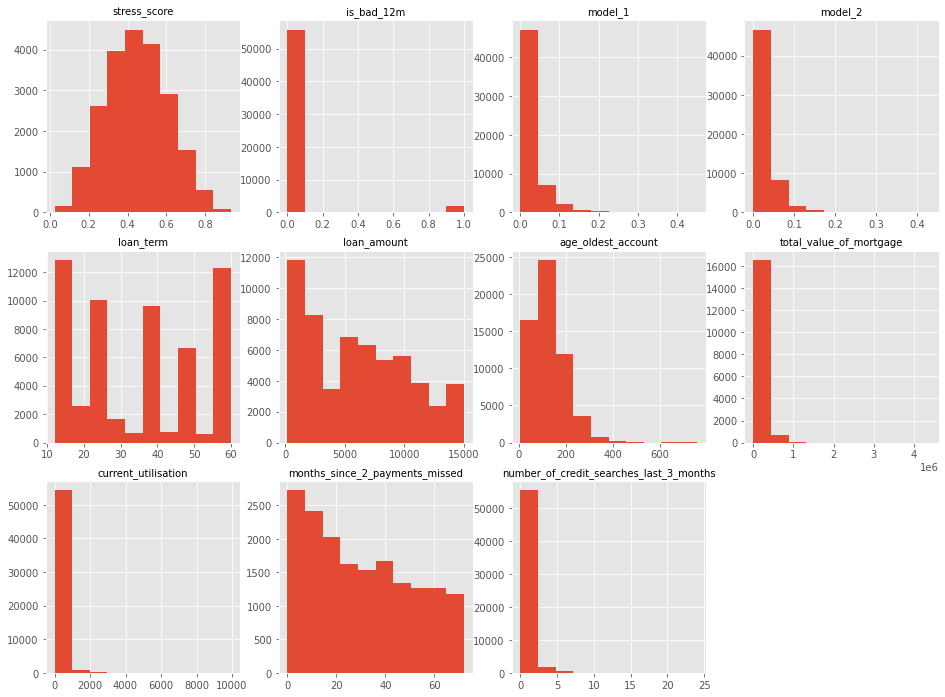

In [400]:
# Take all numerical columns (except for unique_id) from ap_df and plot they distributions in a plt.Subplot
plt.figure(figsize=(16, 12))
features = ap_df.columns
# remove unique_id and origination_date
features = [x for x in features if x not in ['unique_id', 'origination_date']]
print(len(features))

# plot features in a subplot
# Distribution Looks good for all features

for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    ap_df[feature].hist()
    plt.title(feature, fontsize=10)

## Task 1.2: another target
In order to understand the performance of a model before it's too late, we also want to monitor the repayment behaviours after the first few repayments. 

Could you please create another "early-risk" target *is_bad_3m* which represents whether the customers ever had **2 or more** repayments in arrear at any point of their first three scheduled ones?



In [401]:
# reuse function created when removing Nulls for 12m bad flag
ap_df = add_xmonth_default_flag(ap_df, mo_df, 3, col_suffix='')

# Compare to 12m, there need to be strictly fewer defaults in 3m than in 12m -> Correct
print(ap_df['is_bad_3m'].value_counts())
print(ap_df['is_bad_12m'].value_counts())

is_bad_3m
0.0    57159
1.0      550
Name: count, dtype: int64
is_bad_12m
0.0    55784
1.0     1925
Name: count, dtype: int64


# Part 2. Model validation

In this part let's assume we are still at the model development stage and look at the development sample only (see definition at the start). We will skip the model training part here (which is too much fun to finish in 3 hours), and assume that we already trained two candidate models. These are of course probabilistic classification model, which you can find their scores in ***application.csv*** as columns *model_1* and *model_2*. 

We need to compare their performance and decide which one to use in production. The winner model, once deployed, will be used for decisions of

*   Loan approval: the score must be above certain threshold (which can be adjusted during operation) for the application to be approved. 
*   Loss estimate: for each approved loan, we use the model output to predict the probability of default. 
*   Pricing: based on the loss estimate, we decide the interest rate to be charged in order to cover potential losses. 









## Task 2.1: classification power

A common metric used in the credit risk modelling world is the Gini coefficient, which can be linearly mapped to ROCAUC if that's a term you are more familiar with. Could you please compare the Gini's between the two models as a first step? 




<Axes: xlabel='origination_date'>

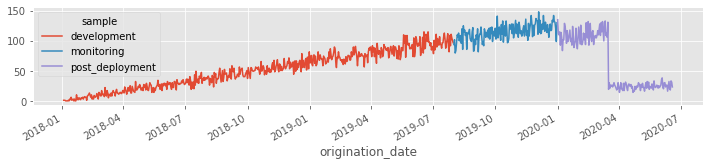

In [402]:
# Split sample into development, monitoring and post deployment
ap_df['sample'] = np.where(ap_df['origination_date'] < pd.to_datetime("2019-08-01"), 'development',
                           np.where(ap_df['origination_date'] < pd.to_datetime("2020-01-01"), 'monitoring', 
                           'post_deployment'))

# Confirm visually that the split worked
ap_df.groupby(['sample', 'origination_date']).size().unstack('sample').plot(figsize=(12,2))

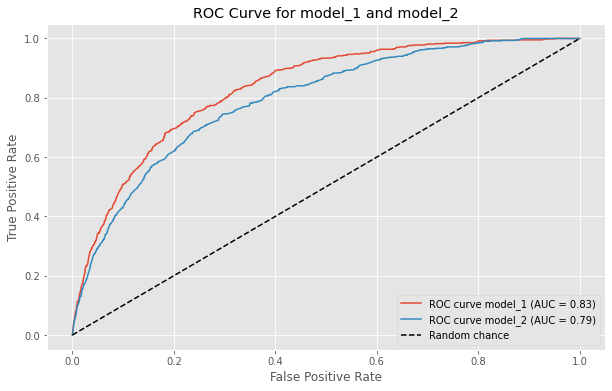

In [403]:
# Results: Model 1 is better than model 2 w.r.t to AUC

def classification_power(df, target, score):
    y_true = df[target]
    y_pred = df[score]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    sample_size = len(y_true)
    bad_rate = round(y_true.mean(),4)
    return auc_score, fpr, tpr, thresholds, sample_size, bad_rate

ap_df_monitoring = ap_df.query('sample=="monitoring"')

auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_m2, fpr_m2, tpr_m2, thresholds_m2, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_2')


# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_m1, tpr_m1, label=f'ROC curve model_1 (AUC = {auc_score_m1:.2f})')
plt.plot(fpr_m2, tpr_m2, label=f'ROC curve model_2 (AUC = {auc_score_m2:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Task 2.2: classification power in segments

As the population of future business might have different distributions from the development sample, we would ideally want the chosen model to be performant in all segments. For simplicity let's stick with univariate segments only.

Could you please compare the Gini's between the two models in the segments of all the variables? Feel free to define the segments as you see appropriate. 


In [404]:
# There is many ways of splitting the variables
# I restrict myself to exactly 2 groups (1 split) per variable
# I will split the dataset along the median for each variable, this ensures equal n for each group
# We will need to check if there is still a sufficient number of bad loans in each group
# We will continue to use the monitoring sample for the model analysis

relevant_features_for_split = ['loan_term', 'loan_amount',
                              'age_oldest_account', 'total_value_of_mortgage', 
                              'current_utilisation', 'months_since_2_payments_missed', 
                              'number_of_credit_searches_last_3_months']


# loop through each feature and split the data
for feature in relevant_features_for_split:
    ap_df_monitoring[f'{feature}_split'] = np.where(ap_df_monitoring[feature] > ap_df_monitoring[feature].median(), 'high', 'low')


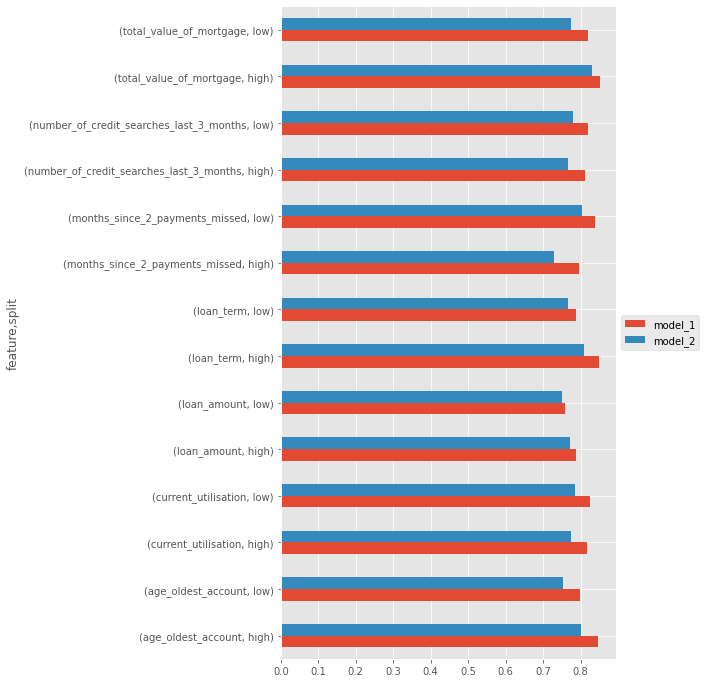

In [405]:
rows = []
for feature in relevant_features_for_split:
    for split in ['high', 'low']:
        for model in ['model_1', 'model_2']:
            auc_score, _, _, _, sample_size, bad_rate = classification_power(ap_df_monitoring.query(f'{feature}_split==@split'), 'is_bad_12m', model)
            rows.append([feature, split, model, auc_score])


# Create a dataframe from the rows
model_performance_segmented = pd.DataFrame(rows, columns=['feature', 'split', 'model', 'auc'])
model_performance_segmented = model_performance_segmented.pivot_table(index=['feature', 'split'], columns='model', values='auc')


# Plot results -> Model 1 performs better in all segments w.r.t to AUC
model_performance_segmented.plot(kind='barh', figsize=(6, 12))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# TODO: Did not check bad rates per segment, it could be that very few failing loans are in some subsamples in which case results might be unreliable


## Task 2.3: accuracy 
As we want to use our model for loss estimates and pricing of each customer, could you please check whether the scores (as probabilistic predictions) are accurate with respect to the actual "bad rates" (i.e. the fraction of *is_bad_12m*=1 among customers of similar scores)


Text(0.5, 1.0, 'Actual bad rate and predicted bad rate per model_1 score decile')

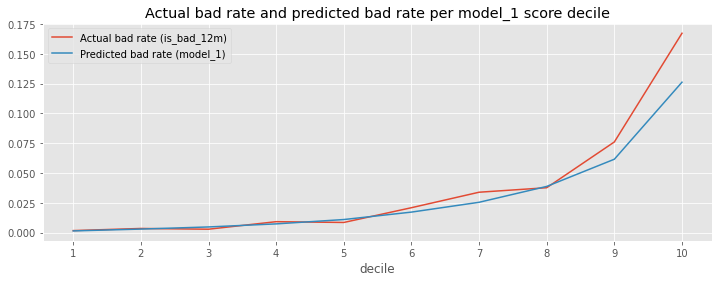

In [406]:
# split ap_df_monitoring into 10 equal portions based on model_1 score
ap_df_monitoring['decile'] = pd.qcut(ap_df_monitoring['model_1'], 10, labels=False) + 1
ap_df_monitoring.groupby('decile').size()
# For each decile and calculate the bad rate based on is_bad_12m and the average model_1 score
bad_rate_per_decile = ap_df_monitoring.groupby('decile').agg({'is_bad_12m':'mean', 'model_1':'mean'})
# plot results as line plot
plt.figure(figsize=(12, 4))
bad_rate_per_decile['is_bad_12m'].plot()
bad_rate_per_decile['model_1'].plot()
plt.legend(['Actual bad rate (is_bad_12m)', 'Predicted bad rate (model_1)'])
t = plt.xticks(range(1, 11))
plt.title('Actual bad rate and predicted bad rate per model_1 score decile')

## Task 2.4: calibration

We also want to monitor the early risk indicator *is_bad_3m* in case something really bad happens (e.g. a pandemic). For that we need to calibrate our scores to the probability of such short-term outcome. Could you please create the calibrated scores for the two models and validate them? (Hint: if this is not a topic you are familiar with, scikit-learn has some handy utilities)

count    17556.000000
mean         0.000057
std          0.007547
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_bad_3m_pred, dtype: float64


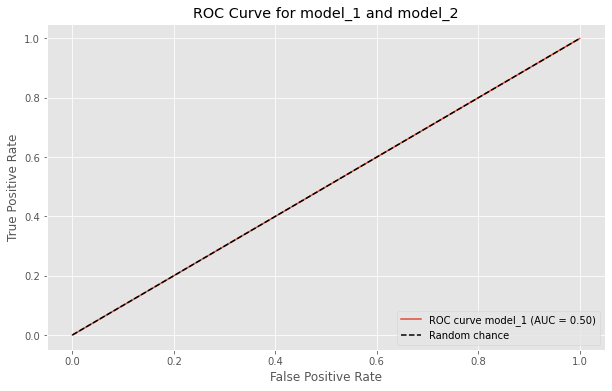

In [412]:
# Not sure if I am doing this right, but I woud just predict is_bad_3m based on the model_1 and model_2 scores

ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

# Run logistic regression on model_1 and model_2 with is_bad_3m as target
# Results: Model 1 is better than model 2
X_train = ap_df_development[['model_1', 'model_2']]
X_test = ap_df_monitoring[['model_1', 'model_2']]
y_train = ap_df_development['is_bad_3m']
y_test = ap_df_monitoring['is_bad_3m']

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(ap_df_monitoring['is_bad_3m_pred'].describe())

# RoC curve of new model
auc_score, fpr, tpr, thresholds, _, _ = classification_power(df=ap_df_monitoring, target='is_bad_3m', score='is_bad_3m_pred')

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve model_1 (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Part 3. Model monitoring

The training and validation of a model is just part of the story. A large part of our work is to understand how our models perform in real life deicisioning and how we adapt to the changing market. In this part we will look into the monitoring sample (see definition at the start).

Now let's assume that we have choosen *model_1* and deployed it to production since 1st Jan 2020. On that day, our decision engine started to use that model, and since then only approved applications with *model_1*<0.05. 


## Task 3.1: model performance

How did the model perform in this monitoring sample, before & after its deployment into production? How does that compare to the expectation from the development sample? 

In [341]:
ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

auc_score_dev, fpr_dev, tpr_dev, thresholds_dev, _, _ = classification_power(ap_df_development, 'is_bad_12m', 'model_1')
auc_score_mon, fpr_mon, tpr_mon, thresholds_mon, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_post, fpr_post, tpr_post, thresholds_post, _, _ = classification_power(ap_df_post_deployment, 'is_bad_12m', 'model_1')

# Calculate precision and recall for threshold<0.05
# Do it for development, monitoring and post deployment
threshold = 0.05
ap_df_development['prediction'] = np.where(ap_df_development['model_1'] > threshold, 1, 0)
ap_df_monitoring['prediction'] = np.where(ap_df_monitoring['model_1'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

# Calculate precision and recall for columns is_bad_12m and prediction
precision_dev = ap_df_development.query('prediction==1')['is_bad_12m'].mean()
recall_dev = ap_df_development.query('is_bad_12m==1')['prediction'].mean()
# same for monitoring
precision_mon = ap_df_monitoring.query('prediction==1')['is_bad_12m'].mean()
recall_mon = ap_df_monitoring.query('is_bad_12m==1')['prediction'].mean()
# same for post deployment
precision_post = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall_post = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()
# Create table with results
res = pd.DataFrame({'precision':[precision_dev, precision_mon, precision_post], 
              'recall':[recall_dev, recall_mon, recall_post]}, 
              index=['development', 'monitoring', 'post deployment'])
# pretty print the results
print(res)


                 precision    recall
development       0.122034  0.651184
monitoring        0.121247  0.657188
post deployment   0.083333  0.010309


## Task 3.2: why the changes?

If you observe a difference, what do you think can be the reason(s)? How are you going to verify your hypothesis?

In [321]:
# This is a little bit surprising. The model was trained for the development sample. 
# If classic oversampling was responsible, one would expect that precision/recall would also drop for the monitoring sample.
# This suggests that the patterns in the out of time sample are different from the development AND monitoring sample. 

## Task 3.3: new variable

You might have noticed that a new variable ***stress_score*** has become available since late 2019. Can you figure out whether there is additional classification power from this variable over our models? 

If so, how would you incorporate it into our decision model?


In [322]:
# Confirm NULL values for stress_score
# Results: Not usable for development set, but available for monitoring (37% missing) and post deployment (0% missing   )
print(ap_df.groupby('sample')['stress_score'].apply(lambda x: x.isnull().mean()))
print(ap_df.groupby('sample').size())


sample
development        1.000000
monitoring         0.376737
post_deployment    0.000000
Name: stress_score, dtype: float64
sample
development        29529
monitoring         17556
post_deployment    10624
dtype: int64


Text(0.5, 1.0, 'Post deployment')

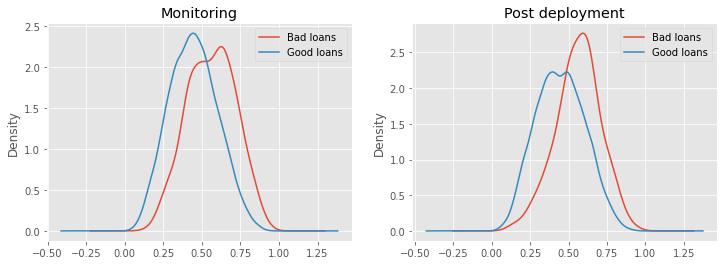

In [336]:
# density function for stress_score split by is_bad_12m
# Results: Stress score is separating good and bad loans somewhat and appears to have predictive power
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

ap_df_monitoring.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_monitoring.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Monitoring')

plt.subplot(1, 2, 2)
ap_df_post_deployment.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_post_deployment.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Post deployment')



In [324]:
# The stress_score variable is somewhat correlated with model_1, however, the correlation is week enough that there still might be predictive power in stress_score
ap_df_monitoring_dropna = ap_df_monitoring.dropna(subset=['stress_score'])
ap_df_post_deployment_dropna = ap_df_post_deployment.dropna(subset=['stress_score'])

# Low, but significant correlation, so we would still expect additional predictive power from stress_score
correlation, p_value = pearsonr(ap_df_monitoring_dropna['stress_score'], ap_df_monitoring_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

# even less of a correlation which would be good for predictive power
correlation, p_value = pearsonr(ap_df_post_deployment_dropna['stress_score'], ap_df_post_deployment_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

Correlation between stress_score and model_1: 0.0454 (p-value: 0.0000)
Correlation between stress_score and model_1: 0.0019 (p-value: 0.8446)


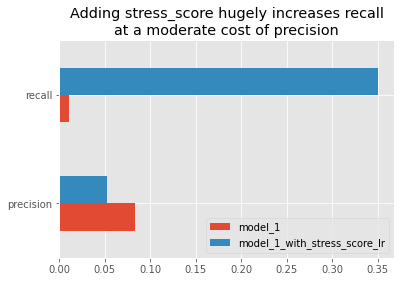

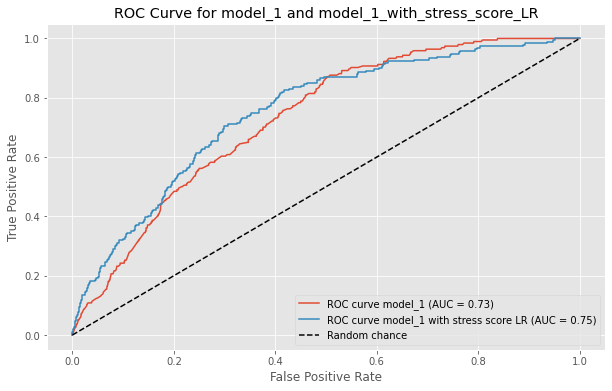

In [354]:
# To prove the predictive power we will fit a logistic regression model with model_1 and stress_score as input variables
# If stress_score is predictive, we would expect the AUC to increase
# We would also expect the precision and recall to increase at the given threshhold
# Other models like Random Forest or Gradient Boosting could be used as well

# Results:
# Adding stress_score as feature in an logistic regression improves AUC slightly and yields a higher RoC curve at most thresholds
# At the predefined threshold, precision is slightly lower for the LR model, but recall is significantly higher


imputer = SimpleImputer(strategy='mean')

X_train = ap_df_monitoring[['model_1', 'stress_score']]
X_train = imputer.fit_transform(X_train)
y_train = ap_df_monitoring['is_bad_12m']

X_test = ap_df_post_deployment[['model_1', 'stress_score']]
X_test = imputer.transform(X_test)
y_test = ap_df_post_deployment['is_bad_12m']


# fit logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# predict
ap_df_post_deployment['model_1_with_stress_score_lr'] = lr.predict_proba(X_test)[:, 1]

# RoC curve for model_1 and model_1_with_stress_score_lr
auc_score_m1s_lr, fpr_m1s_lr, tpr_m1s_lr, thresholds_m1s_lr, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1_with_stress_score_lr')
auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1')

# Precision & Recall for model_1 and model_1_with_stress_score_lr @ threshold 0.05
threshold = 0.05
ap_df_post_deployment['prediction_lr'] = np.where(ap_df_post_deployment['model_1_with_stress_score_lr'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

precision_lr = ap_df_post_deployment.query('prediction_lr==1')['is_bad_12m'].mean()
recall_lr = ap_df_post_deployment.query('is_bad_12m==1')['prediction_lr'].mean()

precision = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()

# Create table with results
res = pd.DataFrame({'precision':[precision, precision_lr], 
              'recall':[recall, recall_lr]}, 
              index=['model_1', 'model_1_with_stress_score_lr'])

# plot the results in table res in a vertical barplot with precision and recall grouped
res.T.plot(kind='barh' , figsize=(6, 4))
plt.title('Adding stress_score hugely increases recall\nat a moderate cost of precision')


# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_m1, tpr_m1, label=f'ROC curve model_1 (AUC = {auc_score_m1:.2f})')
plt.plot(fpr_m1s_lr, tpr_m1s_lr, label=f'ROC curve model_1 with stress score LR (AUC = {auc_score_m1s_lr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_1_with_stress_score_LR')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()